In [1]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs_student_only, \
                            compute_log_likelihood_by_week, \
                            ACTUAL_TRAJ, UNCERTAINTY_PARAMS, \
                            get_positives_by_week, get_true_positives_by_week
import sklearn 
from sklearn.preprocessing import PolynomialFeatures

path = "fall_2021_prior_samples:1633381945"
files = [f for f in listdir(path) if isfile(join(path, f)) and 'with_trajectories' in f ]

path2 = 'fall_2021_prior_samples:1633456006'
files2 = [f for f in listdir(path2) if isfile(join(path2, f)) and 'with_trajectories' in f ]


from vax_sims_LHS_samples import *

import numpy as np

from scipy.stats import poisson, norm

from statsmodels.api import OLS

import matplotlib.pyplot as plt 
import pandas as pd


In [2]:
len(files2)

8062

In [3]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs_student_only(inf_trajs_by_group)
    count += 1
    if count % 100 == 0:
        print("Loaded {} points".format(count))
    
        
        

Loaded 100 points
Loaded 200 points
Loaded 300 points
Loaded 400 points
Loaded 500 points
Loaded 600 points
Loaded 700 points
Loaded 800 points
Loaded 900 points
Loaded 1000 points


In [4]:
sampled_points2 = {}
aggregated_trajs2 = {}

count = 0
for f in files2:
    with open(join(path2, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points2[f] = point
        aggregated_trajs2[f] = aggregate_trajs_student_only(inf_trajs_by_group)
    count += 1
    if count % 100 == 0:
        print("Loaded {} points".format(count))
 

Loaded 100 points
Loaded 200 points
Loaded 300 points
Loaded 400 points
Loaded 500 points
Loaded 600 points
Loaded 700 points
Loaded 800 points
Loaded 900 points
Loaded 1000 points
Loaded 1100 points
Loaded 1200 points
Loaded 1300 points
Loaded 1400 points
Loaded 1500 points
Loaded 1600 points
Loaded 1700 points
Loaded 1800 points
Loaded 1900 points
Loaded 2000 points
Loaded 2100 points
Loaded 2200 points
Loaded 2300 points
Loaded 2400 points
Loaded 2500 points
Loaded 2600 points
Loaded 2700 points
Loaded 2800 points
Loaded 2900 points
Loaded 3000 points
Loaded 3100 points
Loaded 3200 points
Loaded 3300 points
Loaded 3400 points
Loaded 3500 points
Loaded 3600 points
Loaded 3700 points
Loaded 3800 points
Loaded 3900 points
Loaded 4000 points
Loaded 4100 points
Loaded 4200 points
Loaded 4300 points
Loaded 4400 points
Loaded 4500 points
Loaded 4600 points
Loaded 4700 points
Loaded 4800 points
Loaded 4900 points
Loaded 5000 points
Loaded 5100 points
Loaded 5200 points
Loaded 5300 points
Lo

In [5]:
def convert_cum_traj_to_daily_count(traj):
    prev_cum_cases = 0
    daily_count = []
    for current_cum_cases in traj:
        daily_count.append(current_cum_cases - prev_cum_cases)
        prev_cum_cases = current_cum_cases
    return daily_count

def convert_daily_count_traj_to_weekly_count(daily_count_traj):
    weekly_count = []
    lower_idx = 0
    upper_idx = 7 
    while lower_idx <= len(daily_count_traj):
        weekly_count.append(sum(daily_count_traj[lower_idx:upper_idx]))
        lower_idx = upper_idx
        upper_idx += 7
    assert(np.abs(sum(weekly_count) - sum(daily_count_traj)) < 1e-5)
    return weekly_count

def get_weekly_counts(cum_traj):
    daily_count = convert_cum_traj_to_daily_count(cum_traj)
    return convert_daily_count_traj_to_weekly_count(daily_count)



In [6]:
UNCERTAINTY_PARAMS = ['vax_susc_mult', 'vax_transmission_mult', 'contacts_per_day_mult', 'outside_infection_rate_mult',
                      'cases_isolated_per_contact_trace', 'initial_ID_prevalence']

UNCERTAINTY_PARAM_RANGES = {
    'vax_susc_mult': (0.097608, 0.941192), # 0.5194 +/- 1.96 * 0.2152
    'vax_transmission_mult': (0.25, 1),
    'contacts_per_day_mult': (0.9,2.7),
    'outside_infection_rate_mult': (1, 5),
    'cases_isolated_per_contact_trace': (0.5,1.5),
    'initial_ID_prevalence': (0.003, 0.0054)
}

means = []
sds = []

for param in UNCERTAINTY_PARAMS:
    means.append(np.mean(UNCERTAINTY_PARAM_RANGES[param]))
    sds.append((UNCERTAINTY_PARAM_RANGES[param][1] - UNCERTAINTY_PARAM_RANGES[param][0])/(2*1.96))
    
PARAM_MEANS = dict(zip(UNCERTAINTY_PARAMS, means))
PARAM_SDS = dict(zip(UNCERTAINTY_PARAMS, sds))


In [356]:
eps = 1e-10

def compute_lognormal_loglik(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx] + eps))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    #print('means by week', means_by_week)
    
    # compute log likelihood for observed data
    loglik = 0
    for week_idx, actual_positives in enumerate(actual_weekly_traj):
        log_positives = np.log(actual_positives)
        #scaled_log_positives = (log_positives - means_by_week[week_idx]) / stddevs_by_week[week_idx]
        #print(log_positives, means_by_week[week_idx], stddevs_by_week[week_idx], scaled_log_positives)
        #loglik += np.log(norm.pdf(scaled_log_positives))
        loglik += norm.logpdf(log_positives, loc=means_by_week[week_idx], 
                                  scale=stddevs_by_week[week_idx])
    
    return loglik



In [357]:

ACTUAL_TRAJ = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1]#,0,0]

logliks = {}
logliks2 = {}
for f in sampled_points:
    #logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)
    logliks[f] = compute_lognormal_loglik(aggregated_trajs[f])
    if np.isnan(logliks[f]):
        plt.plot(aggregated_trajs[f])
for f in sampled_points2:
    #logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)
    logliks2[f] = compute_lognormal_loglik(aggregated_trajs2[f])

In [358]:
logliks2

{'point_0_with_trajectories.dill': -5166.4409220415555,
 'point_1000_with_trajectories.dill': -20.768218140156733,
 'point_1001_with_trajectories.dill': -5.69000999194456,
 'point_1002_with_trajectories.dill': -6.704971308070547,
 'point_1003_with_trajectories.dill': -136.37728851741548,
 'point_1004_with_trajectories.dill': -666.7152838194427,
 'point_1005_with_trajectories.dill': -15.465709371211918,
 'point_1006_with_trajectories.dill': -150.43022464703708,
 'point_1007_with_trajectories.dill': -990.6396045850194,
 'point_1008_with_trajectories.dill': -9.558011513423008,
 'point_1009_with_trajectories.dill': -14.112623582873772,
 'point_100_with_trajectories.dill': -501.80481092710755,
 'point_1010_with_trajectories.dill': -3041.705344675537,
 'point_1011_with_trajectories.dill': -11.49832393680114,
 'point_1012_with_trajectories.dill': -75.48284699671493,
 'point_1013_with_trajectories.dill': -25.4557977497295,
 'point_1014_with_trajectories.dill': -12.742324723670457,
 'point_1015

In [359]:
len(logliks)

1000

In [360]:

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx]) # sampled parameter values
        param_logliks[param].append(logliks[f]) # log likelihood for corresponding param value
    
    for f in sampled_points2:
        param_vals[param].append(sampled_points2[f][idx]) # sampled parameter values
        param_logliks[param].append(logliks2[f]) # log likelihood for corresponding param value
    

Text(0.5, 1.0, 'distribution of log likelihoods using weekly aggregation')

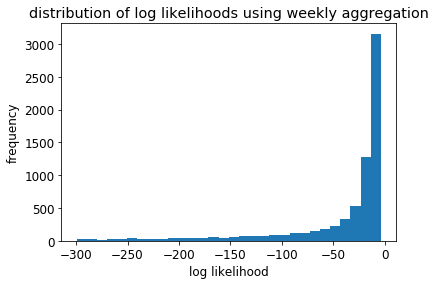

In [361]:
plt.hist([x for x in param_logliks[UNCERTAINTY_PARAMS[0]] 
          if x != float('-inf') and x >= -300], bins=30)
plt.xlabel("log likelihood")
plt.ylabel("frequency")
plt.title("distribution of log likelihoods using weekly aggregation")

In [362]:
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']

print('number of inf likelihood values', np.isinf(df['log_likelihood']).sum())
print('number of nan likelihood values', df['log_likelihood'].isnull().sum())

min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
#df['log_likelihood'].replace(np.nan , min_loglik, inplace=True)
#df['file_name'] = sampled_points
subdf = df
df.shape

# TODO: save df

number of inf likelihood values 0
number of nan likelihood values 0


(9062, 8)

In [363]:
df


,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult
0,0.748766,0.833479,1.043564,2.515498,1.065157,0.006487,-65.984710,0.651268
1,0.707515,0.451851,1.708060,3.683021,0.532544,0.003432,-154.746289,0.546052
2,0.778271,0.498263,0.844716,2.662501,0.470991,0.003662,-17.990392,0.327567
3,0.722875,0.584793,2.346443,5.844724,0.795168,0.003987,-2540.137248,0.991918
4,0.682521,0.544387,1.234107,2.005781,1.229614,0.004297,-7.302927,0.458539
...,...,...,...,...,...,...,...,...
9057,0.719076,0.317916,1.755357,1.743523,0.843077,0.004491,-6.105606,0.401284
9058,0.539311,0.757518,2.330040,3.689904,1.331967,0.004149,-291.269832,0.951910
9059,0.430671,0.663417,1.692162,4.091402,1.182631,0.003713,-7.049510,0.483475
9060,0.536671,0.580785,2.488349,3.802151,0.857962,0.004360,-183.289413,0.775594


In [364]:
log_priors = []

for row in range(df.shape[0]):
    log_prior = 0
    for param in UNCERTAINTY_PARAMS:
        log_prior += -np.log(PARAM_SDS[param]*np.sqrt(2*np.pi)) -1/2 * (df.loc[row][param]-PARAM_MEANS[param])**2/PARAM_SDS[param]**2
    log_priors.append(log_prior)


In [365]:
df['log_prior'] = log_priors
df['log_posterior'] = df['log_likelihood'] + df['log_prior']

In [366]:
df.to_csv('Oct8_posterior_data.csv')

In [367]:
#np.isinf(df['log_likelihood']).sum()
df['log_likelihood'].isnull().sum()

0

In [368]:
subdf_diff = subdf[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult', \
               'log_posterior']]
#subtract from entry with largest log -- to change to posterior
subdf_diff = subdf_diff.sub(subdf_diff.iloc[subdf['log_posterior'].idxmax()])
subdf_diff = subdf_diff.dropna(subset=['log_posterior'])


# TODO: scale distances by sd
subdf_diff

,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,combined_spread_mult,log_posterior
0,-0.579814,0.074704,0.002209,0.269250,-70.089092
1,0.587709,-0.457909,-0.000846,0.164035,-152.711404
2,-0.432810,-0.519462,-0.000616,-0.054451,-18.153299
3,2.749412,-0.195286,-0.000291,0.609900,-2540.048019
4,-1.089531,0.239160,0.000019,0.076521,-3.795130
...,...,...,...,...,...
9057,-1.351789,-0.147377,0.000213,0.019267,-3.353668
9058,0.594593,0.341514,-0.000129,0.569892,-287.723433
9059,0.996090,0.192177,-0.000565,0.101457,-2.791584
9060,0.706839,-0.132492,0.000082,0.393576,-179.405629


In [369]:
subdf_diff.std()

outside_infection_rate_mult            1.014636
cases_isolated_per_contact_trace       0.257675
initial_ID_prevalence                  0.000606
combined_spread_mult                   0.351530
log_posterior                       1487.179312
dtype: float64

In [370]:
subdf.iloc[subdf['log_posterior'].idxmax()]

vax_susc_mult                       0.540415
vax_transmission_mult               0.368909
contacts_per_day_mult               1.916183
outside_infection_rate_mult         3.095312
cases_isolated_per_contact_trace    0.990454
initial_ID_prevalence               0.004278
log_likelihood                     -4.589688
combined_spread_mult                0.382018
log_prior                           6.253123
log_posterior                       1.663434
Name: 4050, dtype: float64

In [371]:
params_diff = subdf_diff[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult']]
logposterior_diff = subdf_diff['log_posterior']
quadratic = PolynomialFeatures(degree = 2,interaction_only=False,include_bias = False)


0.5544239358272471


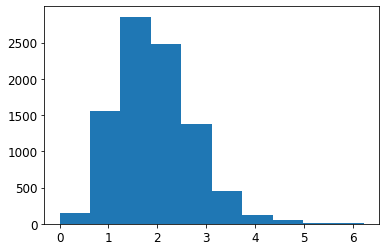

In [372]:
param_distances = np.sqrt(np.square(params_diff/params_diff.std()).sum(axis=1))

plt.hist(param_distances)
cutoff_radius = np.quantile(param_distances,0.01)
print(cutoff_radius)

In [373]:
reg_x = params_diff[param_distances < cutoff_radius]
reg_y = logposterior_diff[param_distances < cutoff_radius]
reg_x.reset_index(drop=True, inplace=True)
reg_y.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Histogram of (log posterior - max log posterior)\n among the regression datapoints, eps = 1e-10')

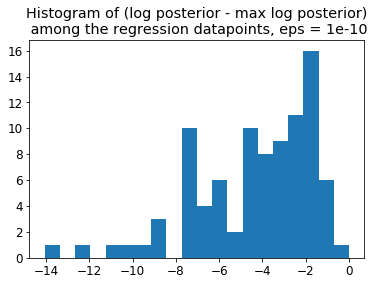

In [391]:
plt.hist(reg_y, bins=20)
plt.title('Histogram of (log posterior - max log posterior)\n among the regression datapoints, eps = '+str(eps))

In [375]:
reg_input_quadratic = pd.DataFrame(quadratic.fit_transform(reg_x.to_numpy()),\
                                     columns = quadratic.get_feature_names(reg_x.columns))


In [376]:
norm_reg_input_quadratic = reg_input_quadratic / reg_input_quadratic.abs().max()


In [377]:
reg_input_quadratic.abs().max()

outside_infection_rate_mult                                     5.269818e-01
cases_isolated_per_contact_trace                                1.338620e-01
initial_ID_prevalence                                           2.764997e-04
combined_spread_mult                                            1.792233e-01
outside_infection_rate_mult^2                                   2.777098e-01
outside_infection_rate_mult cases_isolated_per_contact_trace    3.330744e-02
outside_infection_rate_mult initial_ID_prevalence               7.479798e-05
outside_infection_rate_mult combined_spread_mult                4.891306e-02
cases_isolated_per_contact_trace^2                              1.791903e-02
cases_isolated_per_contact_trace initial_ID_prevalence          2.151475e-05
cases_isolated_per_contact_trace combined_spread_mult           1.244513e-02
initial_ID_prevalence^2                                         7.645207e-08
initial_ID_prevalence combined_spread_mult                      2.656279e-05

In [378]:
#norm_reg_input_quadratic.isnull().sum()
#np.isinf(norm_reg_input_quadratic).sum()
reg_y.isnull().sum()
#np.isinf(reg_y).sum()

0

In [379]:

model = OLS(reg_y, norm_reg_input_quadratic)
results = model.fit()

In [380]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          log_posterior   R-squared (uncentered):                   0.782
Model:                            OLS   Adj. R-squared (uncentered):              0.743
Method:                 Least Squares   F-statistic:                              19.75
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                    6.00e-20
Time:                        17:11:44   Log-Likelihood:                         -208.79
No. Observations:                  91   AIC:                                      445.6
Df Residuals:                      77   BIC:                                      480.7
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
outside_infection_rate_mult                                      1.0720      0.786      1.364      0.177      -0.493       2.637
cases_isolated_per_contact_trace                                -0.6464      0.632     -1.022      0.310      -1.906       0.613
initial_ID_prevalence                                           -0.4074      0.620     -0.657      0.513      -1.643       0.828
combined_spread_mult                                             2.6732      0.740      3.613      0.001       1.200       4.146
outside_infection_rate_mult^2                                   -3.7587      1.351     -2.782      0.007      -6.449      -1.069
outside_infection_rate_mult cases_isolated_per_contact_trace     0.2230      0.927      0.241      0.810      -1.622       2.069
outside_infection_rate_mult initial_ID_prevalence                0.3019      0.901      0.335      0.738      -1.491       2.095
outside_infection_rate_mult combined_spread_mult                -0.0540      1.075     -0.050      0.960      -2.194       2.086
cases_isolated_per_contact_trace^2                              -4.0798      1.082     -3.771      0.000      -6.234      -1.925
cases_isolated_per_contact_trace initial_ID_prevalence          -0.9317      0.781     -1.194      0.236      -2.486       0.623
cases_isolated_per_contact_trace combined_spread_mult            2.3532      0.893      2.636      0.010       0.576       4.131
initial_ID_prevalence^2                                         -3.4257      1.010     -3.393      0.001      -5.436      -1.415
initial_ID_prevalence combined_spread_mult                       0.9056      0.960      0.944      0.348      -1.006       2.817
combined_spread_mult^2                                          -9.9173      1.231     -8.059      0.000     -12.368      -7.467
==============================================================================
Omnibus:                       22.380   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.501
Skew:                          -0.937   Prob(JB):                     5.90e-10
Kurtosis:                       5.775   Cond. No.                         3.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [381]:
results.params

outside_infection_rate_mult                                     1.071987
cases_isolated_per_contact_trace                               -0.646448
initial_ID_prevalence                                          -0.407413
combined_spread_mult                                            2.673199
outside_infection_rate_mult^2                                  -3.758743
outside_infection_rate_mult cases_isolated_per_contact_trace    0.223033
outside_infection_rate_mult initial_ID_prevalence               0.301877
outside_infection_rate_mult combined_spread_mult               -0.053960
cases_isolated_per_contact_trace^2                             -4.079839
cases_isolated_per_contact_trace initial_ID_prevalence         -0.931730
cases_isolated_per_contact_trace combined_spread_mult           2.353189
initial_ID_prevalence^2                                        -3.425705
initial_ID_prevalence combined_spread_mult                      0.905558
combined_spread_mult^2                             

In [382]:
unnorm_coef = results.params / reg_input_quadratic.abs().max()

In [383]:
unnorm_coef

outside_infection_rate_mult                                     2.034201e+00
cases_isolated_per_contact_trace                               -4.829213e+00
initial_ID_prevalence                                          -1.473465e+03
combined_spread_mult                                            1.491547e+01
outside_infection_rate_mult^2                                  -1.353479e+01
outside_infection_rate_mult cases_isolated_per_contact_trace    6.696191e+00
outside_infection_rate_mult initial_ID_prevalence               4.035904e+03
outside_infection_rate_mult combined_spread_mult               -1.103182e+00
cases_isolated_per_contact_trace^2                             -2.276819e+02
cases_isolated_per_contact_trace initial_ID_prevalence         -4.330655e+04
cases_isolated_per_contact_trace combined_spread_mult           1.890851e+02
initial_ID_prevalence^2                                        -4.480853e+07
initial_ID_prevalence combined_spread_mult                      3.409121e+04

In [384]:
# map regression results to hessian matrix

hessian = np.zeros((4,4))

counter = 0
for i in range(4):
    for j in range(i, 4):
        if i == j:
            hessian[i,j] = -2 * unnorm_coef[4+counter]
        else:
            hessian[i,j] = -unnorm_coef[4+counter]
        counter += 1

# fill in symmetric lower triangular part
for i in range(1,4):
    for j in range(i):
        hessian[i,j] = hessian[j,i]
    
print(hessian)

[[ 2.70695766e+01 -6.69619054e+00 -4.03590446e+03  1.10318226e+00]
 [-6.69619054e+00  4.55363747e+02  4.33065507e+04 -1.89085128e+02]
 [-4.03590446e+03  4.33065507e+04  8.96170632e+07 -3.40912141e+04]
 [ 1.10318226e+00 -1.89085128e+02 -3.40912141e+04  6.17497759e+02]]


In [385]:
# order of parameters in the eigenvectors:
#   outside_infection_rate_mult                                     
#   cases_isolated_per_contact_trace                               
#   initial_ID_prevalence                                         
#   combined_spread_mult 
np.set_printoptions(linewidth = 100)
np.linalg.eig(hessian)

(array([8.96170972e+07, 2.68207471e+01, 3.27117998e+02, 7.11914236e+02]),
 array([[ 4.50350289e-05, -9.99894570e-01, -1.41805196e-02,  3.12405875e-03],
        [-4.83242998e-04, -1.36907352e-02,  8.48981821e-01, -5.28244449e-01],
        [-9.99999810e-01, -4.02549652e-05, -2.09956824e-04,  5.78414975e-04],
        [ 3.80413281e-04, -4.83849727e-03,  5.28231707e-01,  8.49086396e-01]]))

In [386]:
post_mean = np.matmul(np.linalg.inv(hessian), unnorm_coef[:4]) + subdf[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult']].iloc[subdf['log_posterior'].idxmax()]
# posterior mean
post_mean

outside_infection_rate_mult         3.169042
cases_isolated_per_contact_trace    0.991338
initial_ID_prevalence               0.004274
combined_spread_mult                0.406069
Name: 4050, dtype: float64

In [387]:
# posterior covariance
post_covar = np.linalg.inv(hessian)
post_covar

array([[ 3.72773362e-02,  4.71278033e-04,  1.51237012e-06,  1.61209500e-04],
       [ 4.71278033e-04,  2.60234381e-03, -9.53542521e-07,  7.43382752e-04],
       [ 1.51237012e-06, -9.53542521e-07,  1.18237070e-08,  3.58082918e-07],
       [ 1.61209500e-04,  7.43382752e-04,  3.58082918e-07,  1.86655295e-03]])

In [388]:
cred_ints = []
for i in range(4):
    cred_ints.append([post_mean[i] - 1.96 * np.sqrt(post_covar[i,i]), post_mean[i] + 1.96 * np.sqrt(post_covar[i,i])] )

In [389]:
# 95% credible intervals
cred_ints

[[2.7906176753192877, 3.54746538674887],
 [0.8913521856664982, 1.0913238233489486],
 [0.004060609617778548, 0.004486858150702932],
 [0.32138948286049224, 0.49074768076362757]]

In [390]:
np.corrcoef(post_covar)

array([[ 1.        , -0.27193467,  0.83354569, -0.41729366],
       [-0.27193467,  1.        , -0.68536257,  0.26065025],
       [ 0.83354569, -0.68536257,  1.        , -0.17054271],
       [-0.41729366,  0.26065025, -0.17054271,  1.        ]])

In [102]:
def estimate_marginal_distribution(param_vals, logliks, num_bins):
    bin_boundaries = np.linspace(min(param_vals), max(param_vals), num=num_bins)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    bin_width = bin_boundaries[1] - bin_boundaries[0]
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        if bin_end_val == max(param_vals):
            bin_end_val += 1
        likelihoods = [np.exp(loglik) for (param_val, loglik) in zip(param_vals, logliks)
                      if param_val >= bin_start_val and param_val < bin_end_val and 
                      loglik != float('-inf')]
        
        avg_lik = np.log(np.sum(likelihoods))
        bin_likelihoods.append(avg_lik)
    return bin_centres, bin_likelihoods, bin_width
   

/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


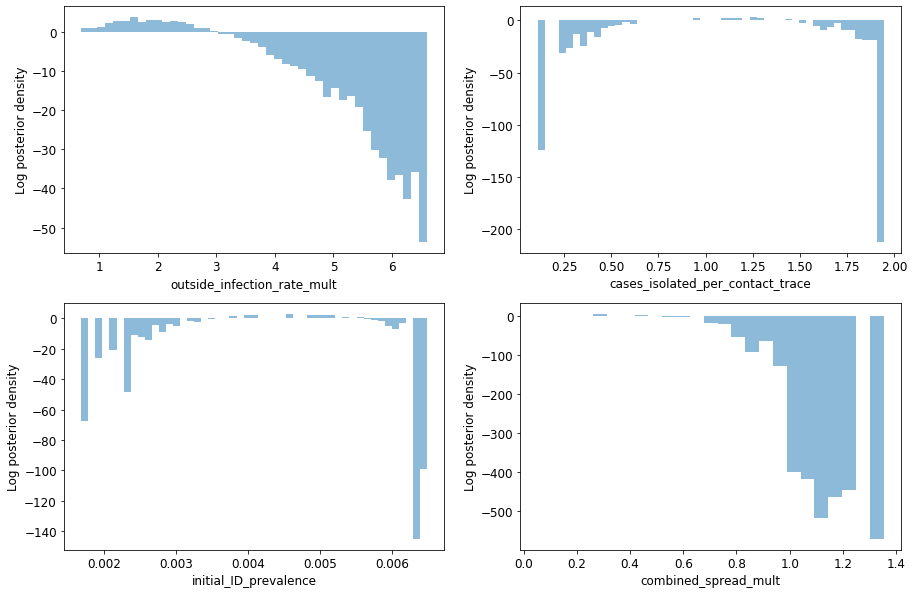

In [104]:
plt.figure(figsize=(15,10))


for idx in range(4):
    param = subdf_diff.columns[idx]
    plt.subplot(2,2,idx+1)
    centres, likelihoods, bin_width = estimate_marginal_distribution(df[param], df['log_posterior'], 50)
    plt.bar(centres, likelihoods, width = bin_width,
            alpha=0.5)
    plt.xlabel("{}".format(param))
    plt.ylabel('Log posterior density')
    #plt.title("{}".format(param))

In [141]:
max_posterior_point = subdf.iloc[subdf['log_posterior'].idxmax()]
max_posterior_point

vax_susc_mult                       0.526847
vax_transmission_mult               0.249375
contacts_per_day_mult               1.651973
outside_infection_rate_mult         1.635626
cases_isolated_per_contact_trace    0.950860
initial_ID_prevalence               0.004590
log_likelihood                     -2.468432
combined_spread_mult                0.217041
log_prior                           4.103804
log_posterior                       1.635372
Name: 4997, dtype: float64

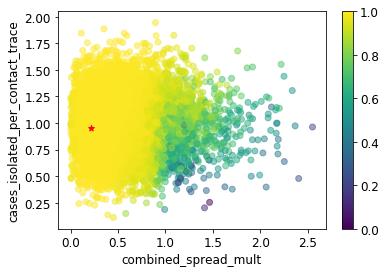

In [127]:
key1, key2 = 'combined_spread_mult', 'cases_isolated_per_contact_trace'
plt.scatter(df[key1], df[key2],
           c=df['log_posterior'], alpha=0.5)
plt.xlabel(key1)
plt.ylabel(key2)
plt.scatter(max_posterior_point[key1], max_posterior_point[key2], marker='*', color='r')
plt.colorbar()

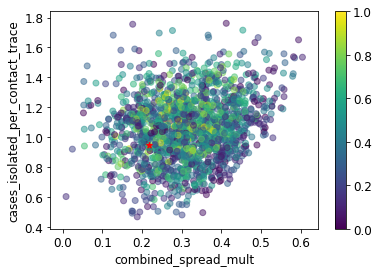

In [129]:
subdf_plot = df[df['log_posterior'] >= -10]
key1, key2 = 'combined_spread_mult', 'cases_isolated_per_contact_trace'
plt.scatter(subdf_plot[key1], subdf_plot[key2],
           c=subdf_plot['log_posterior'], alpha=0.5)
plt.xlabel(key1)
plt.ylabel(key2)
plt.scatter(max_posterior_point[key1], max_posterior_point[key2], marker='*', color='r')
plt.colorbar()

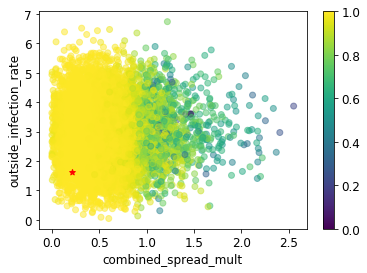

In [134]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_posterior'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.scatter(max_posterior_point['combined_spread_mult'], max_posterior_point['outside_infection_rate_mult'], marker='*', color='r')

plt.colorbar()
plt.show()



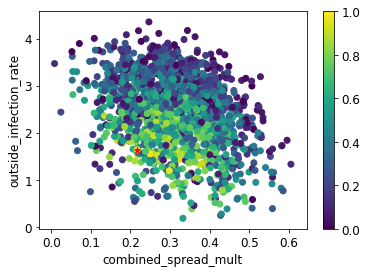

In [135]:
plt.scatter(subdf_plot['combined_spread_mult'], subdf_plot['outside_infection_rate_mult'],
           c=subdf_plot['log_posterior'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.scatter(max_posterior_point['combined_spread_mult'], max_posterior_point['outside_infection_rate_mult'], marker='*', color='r')

plt.colorbar()

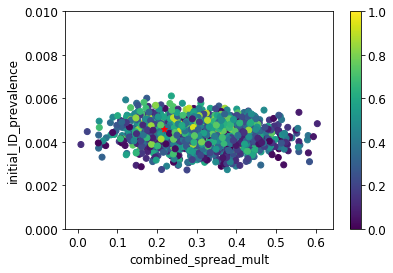

In [138]:
plt.scatter(subdf_plot['combined_spread_mult'], subdf_plot['initial_ID_prevalence'],
           c=subdf_plot['log_posterior'])
plt.xlabel('combined_spread_mult')
plt.ylabel('initial_ID_prevalence')
plt.ylim(0, 0.01)
plt.scatter(max_posterior_point['combined_spread_mult'], max_posterior_point['initial_ID_prevalence'], marker='*', color='r')

plt.colorbar()

In [123]:
max_posterior_point = subdf.iloc[subdf['log_posterior'].idxmax()]

In [124]:
max_posterior_point

vax_susc_mult                       0.526847
vax_transmission_mult               0.249375
contacts_per_day_mult               1.651973
outside_infection_rate_mult         1.635626
cases_isolated_per_contact_trace    0.950860
initial_ID_prevalence               0.004590
log_likelihood                     -2.468432
combined_spread_mult                0.217041
log_prior                           4.103804
log_posterior                       1.635372
Name: 4997, dtype: float64